# Portfolio Optimization Project
Kripa Bansal\
Sophia Ford\
Natalia Ramirez

Constructing a portfolio with the best possible balance of risk (variance) and expected return (mean returns). 

## Data Cleaning

In [7]:
import sys
print(sys.executable)

c:\Users\sford\anaconda3\python.exe


In [8]:
pip install Sequential

Note: you may need to restart the kernel to use updated packages.


In [9]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Stocks we will use
tickers = ['KRE', 'DIS', 'GOOGL', 'NG=F']
#Final and start dates
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)
print(end_date)
print(start_date)

2024-05-12 14:43:13.872133
2014-05-15 14:43:13.872133


### Reading Data

In [11]:
# Initialize a list to hold the DataFrames
dataframes = []

for name in tickers:
    # Download stock data for given ticker between the start and end dates
    data = yf.download(name, start=start_date, end=end_date)
    
    # Add a new column for the ticker name
    data['Ticker'] = name
    
    # Append the DataFrame to the list
    dataframes.append(data)

stock_info = pd.concat(dataframes)

stock_info.reset_index(inplace=True)

print(stock_info)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

            Date       Open       High        Low      Close  Adj Close  \
0     2014-05-15  37.380001  37.430000  36.590000  37.380001  29.678005   
1     2014-05-16  37.279999  37.380001  36.950001  37.299999  29.614494   
2     2014-05-19  37.119999  37.910000  37.119999  37.900002  30.090857   
3     2014-05-20  37.830002  37.880001  37.240002  37.509998  29.781219   
4     2014-05-21  37.740002  38.060001  37.450001  37.770000  29.987644   
...          ...        ...        ...        ...        ...        ...   
10054 2024-05-06   2.170000   2.262000   2.133000   2.195000   2.195000   
10055 2024-05-07   2.206000   2.230000   2.142000   2.207000   2.207000   
10056 2024-05-08   2.219000   2.274000   2.167000   2.187000   2.187000   
10057 2024-05-09   2.186000   2.316000   2.153000   2.301000   2.301000   
10058 2024-05-10   2.307000   2.344000   2.242000   2.252000   2.252000   

        Volume Ticker  
0      5511100    KRE  
1      2038200    KRE  
2      2799000    KRE  
3  

In [12]:
print(stock_info['Date'])

0       2014-05-15
1       2014-05-16
2       2014-05-19
3       2014-05-20
4       2014-05-21
           ...    
10054   2024-05-06
10055   2024-05-07
10056   2024-05-08
10057   2024-05-09
10058   2024-05-10
Name: Date, Length: 10059, dtype: datetime64[ns]


## Plotting Adj. Close Price

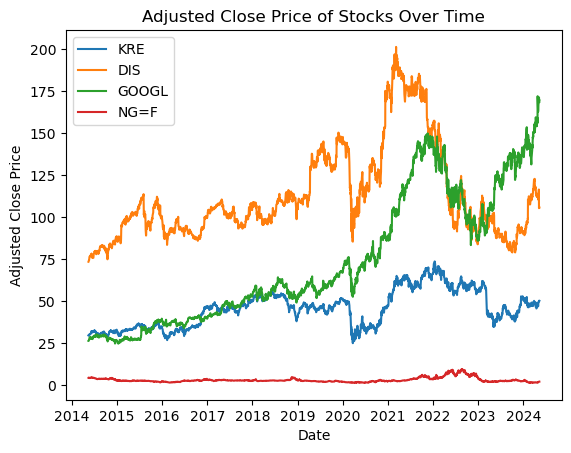

In [13]:
import matplotlib.pyplot as plt

# Create a plot to show closing price of each ticker
for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

# Show the plot
plt.show()

## Daily Simple Return

In [14]:
returns = pd.DataFrame()

for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    ticker_change = subset.set_index('Date')['Adj Close'].pct_change()  # Keep the date index

    returns[ticker] = ticker_change  # This ensures the Date remains as the index

returns.dropna(how='all', inplace=True)

# Check the resulting DataFrame
print(returns.head())

                 KRE       DIS     GOOGL      NG=F
Date                                              
2014-05-16 -0.002140  0.002994 -0.001550 -0.012531
2014-05-19  0.016085  0.008210  0.019932  0.012916
2014-05-20 -0.010290  0.000493  0.002895  0.018345
2014-05-21  0.006931  0.013566  0.017228 -0.017355
2014-05-22  0.005030  0.001946  0.010460 -0.025486


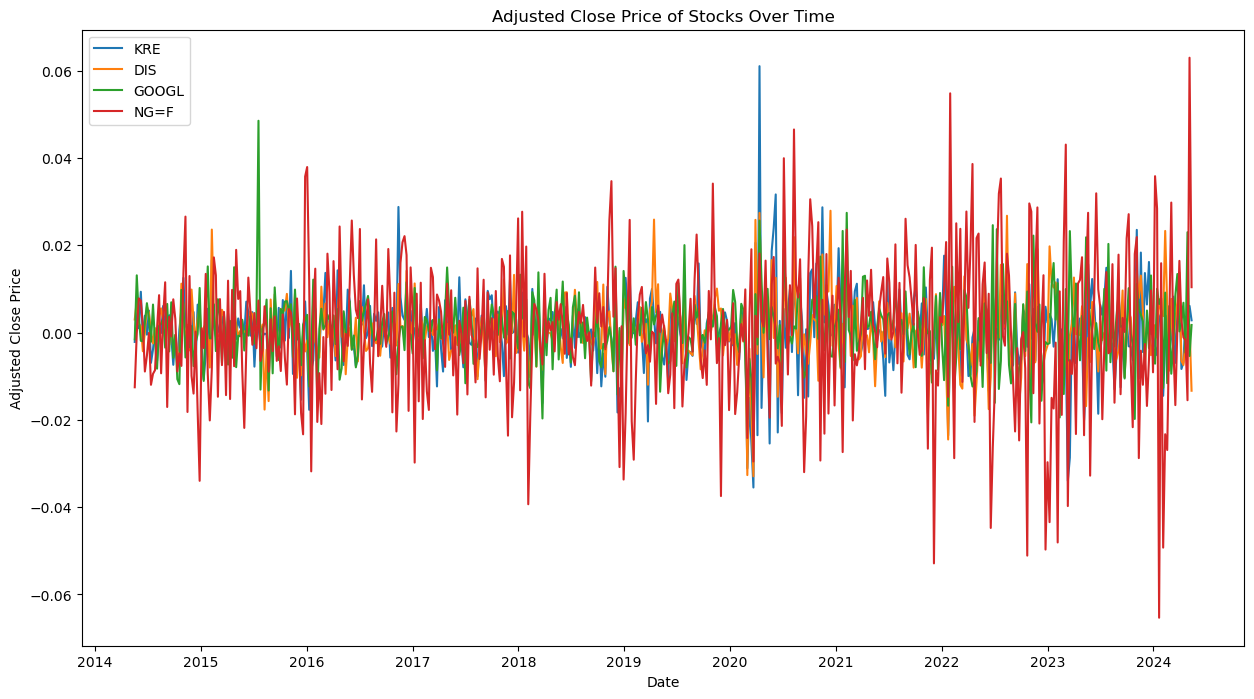

In [15]:
plt.figure(figsize=(15, 8))
weekly_returns = returns.resample('W').mean()
for ticker in returns.columns:
    plt.plot(weekly_returns.index, weekly_returns[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

plt.show()

## Creating Covariance Matrix

In [16]:
cov_matrix = returns.cov()
print(cov_matrix)

            KRE       DIS     GOOGL      NG=F
KRE    0.000378  0.000179  0.000129  0.000051
DIS    0.000179  0.000302  0.000133  0.000036
GOOGL  0.000129  0.000133  0.000314  0.000022
NG=F   0.000051  0.000036  0.000022  0.001468


### Mean Weights

In [17]:
mean_returns = returns.mean()
num_assets = len(returns.columns)

## Defining Metrics

Through mean, variance, and covariance we can formulate an optimization problem where you aim to minimize the portfolio's variance given expected returns or maximize the expected return for a given level of risk.\
**Formula:**
$\sigma^2_p = w^T \Sigma w$
### Efficient Frontier 
The set of optimal portfolios that offer the highest returns with a low level of risk or the lowest risk with the highest returns is known as the Efficient Frontier. 

In [18]:
 def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    # Weights must range from 0-1
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

Mean returns helps in estimating the expected return of each asset and thus the return of the whole portfolio

## Optimizing Weights

Identifying the portfolio with less mean variance 

In [19]:
from scipy.optimize import minimize
def portfolio_variance(weights):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def portfolio_sharpe(weights):
    return -((portfolio_performance(weights, mean_returns, cov_matrix)[1] - risk_free_rate) / portfolio_performance(weights, mean_returns, cov_matrix)[0])

In [20]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must be 1
bounds = tuple((0,1) for asset in range(num_assets)) 
risk_free_rate = 0.0001#We would like a risk of 1%

In [21]:
# All stocks have the same weights at the start
initial_weights = np.array(num_assets * [1. / num_assets])

In [22]:
# Minimum variance
optimal_var_min = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Maximize Sharpe Ratio
optimal_sharpe = minimize(portfolio_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

In [23]:
# Calculate unweighted returns using uniform weights
uniformly_weighted_returns = np.dot(returns, initial_weights.T)
unweighted_returns = returns.copy()
unweighted_returns['Unweighted_Returns'] = uniformly_weighted_returns
print(unweighted_returns.head())

                 KRE       DIS     GOOGL      NG=F  Unweighted_Returns
Date                                                                  
2014-05-16 -0.002140  0.002994 -0.001550 -0.012531           -0.003307
2014-05-19  0.016085  0.008210  0.019932  0.012916            0.014286
2014-05-20 -0.010290  0.000493  0.002895  0.018345            0.002861
2014-05-21  0.006931  0.013566  0.017228 -0.017355            0.005093
2014-05-22  0.005030  0.001946  0.010460 -0.025486           -0.002012


In [24]:
# Calculate optimized weighted returns
print('Optimal weights for minimum variance')
weights_min_var = optimal_var_min['x']
print(weights_min_var)
weighted_returns = np.dot(returns, weights_min_var.T)
returns['Weighted_Returns'] = weighted_returns 
returns.head()

Optimal weights for minimum variance
[0.20020603 0.32513607 0.36827042 0.10638748]


,KRE,DIS,GOOGL,NG=F,Weighted_Returns
Date,,,,,
2014-05-16,-0.002140,0.002994,-0.001550,-0.012531,-0.001359
2014-05-19,0.016085,0.008210,0.019932,0.012916,0.014604
2014-05-20,-0.010290,0.000493,0.002895,0.018345,0.001118
2014-05-21,0.006931,0.013566,0.017228,-0.017355,0.010297
2014-05-22,0.005030,0.001946,0.010460,-0.025486,0.002781


## Create features

Using rolling weighted returns, the standard deviation of the weighted returns, and the previous returns. Along with the rolling closing prices in a window of 10 and 50 days. 

### Weighted Returns

In [25]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-16,-0.002140,0.002994,-0.001550,-0.012531,-0.001359,NaN,NaN,NaN
2014-05-19,0.016085,0.008210,0.019932,0.012916,0.014604,NaN,NaN,-0.001359
2014-05-20,-0.010290,0.000493,0.002895,0.018345,0.001118,NaN,NaN,0.014604
2014-05-21,0.006931,0.013566,0.017228,-0.017355,0.010297,NaN,NaN,0.001118
2014-05-22,0.005030,0.001946,0.010460,-0.025486,0.002781,NaN,NaN,0.010297


In [26]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
# Volatility
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns = returns.dropna(subset=['MA_10', 'STD_10'])
returns.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-30,-0.000522,-0.000238,0.001910,-0.003729,0.000125,0.005088,0.006618,0.000257
2014-06-02,0.011491,0.003095,-0.012788,0.015412,0.000237,0.005247,0.006463,0.000125
2014-06-03,0.003356,-0.004628,-0.017419,0.003686,-0.006855,0.003101,0.006573,0.000237
2014-06-04,0.002316,0.004292,-0.001353,0.002376,0.001614,0.003151,0.006558,-0.006855
2014-06-05,0.019255,0.006410,0.020171,0.013147,0.014766,0.003598,0.007218,0.001614


### Unweighted Returns

In [27]:
unweighted_returns['MA_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).mean()
unweighted_returns['STD_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).std()
unweighted_returns['Previous_Returns'] = unweighted_returns['Unweighted_Returns'].shift(1)
unweighted_returns.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-16,-0.002140,0.002994,-0.001550,-0.012531,-0.003307,NaN,NaN,NaN
2014-05-19,0.016085,0.008210,0.019932,0.012916,0.014286,NaN,NaN,-0.003307
2014-05-20,-0.010290,0.000493,0.002895,0.018345,0.002861,NaN,NaN,0.014286
2014-05-21,0.006931,0.013566,0.017228,-0.017355,0.005093,NaN,NaN,0.002861
2014-05-22,0.005030,0.001946,0.010460,-0.025486,-0.002012,NaN,NaN,0.005093


In [28]:
unweighted_returns['MA_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).mean()
unweighted_returns['STD_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).std()
unweighted_returns['Previous_Returns'] = unweighted_returns['Unweighted_Returns'].shift(1)
unweighted_returns = unweighted_returns.dropna(subset=['MA_10', 'STD_10'])
unweighted_returns.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-30,-0.000522,-0.000238,0.001910,-0.003729,-0.000645,0.004186,0.006825,-0.002044
2014-06-02,0.011491,0.003095,-0.012788,0.015412,0.004303,0.004946,0.006301,-0.000645
2014-06-03,0.003356,-0.004628,-0.017419,0.003686,-0.003751,0.003143,0.005899,0.004303
2014-06-04,0.002316,0.004292,-0.001353,0.002376,0.001908,0.003047,0.005912,-0.003751
2014-06-05,0.019255,0.006410,0.020171,0.013147,0.014746,0.004013,0.006975,0.001908


### Original Stock DF Features

In [29]:
stock_info['Date'] = pd.to_datetime(stock_info['Date'])
# Set 'Date' as the index for both DataFrames.
stock_info.set_index('Date', inplace=True)
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2014-05-15,37.380001,37.430000,36.590000,37.380001,29.678005,5511100,KRE
2014-05-16,37.279999,37.380001,36.950001,37.299999,29.614494,2038200,KRE
2014-05-19,37.119999,37.910000,37.119999,37.900002,30.090857,2799000,KRE
2014-05-20,37.830002,37.880001,37.240002,37.509998,29.781219,3538600,KRE
2014-05-21,37.740002,38.060001,37.450001,37.770000,29.987644,2137300,KRE


In [30]:
stock_info['MA_10_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=10).mean())
stock_info['MA_50_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=50).mean())
stock_info = stock_info.dropna(subset=['MA_10_close', 'MA_50_close'])
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,MA_10_close,MA_50_close
Date,,,,,,,,,
2014-07-25,38.900002,39.209999,38.799999,39.119999,31.188442,2141500,KRE,31.186046,31.370291
2014-07-28,39.200001,39.270000,38.520000,38.689999,30.845621,3850100,KRE,31.099944,31.393644
2014-07-29,38.669998,38.990002,38.669998,38.709999,30.861563,1428900,KRE,30.987532,31.418585
2014-07-30,39.000000,39.330002,38.790001,39.070000,31.148567,3251800,KRE,30.953249,31.439739
2014-07-31,38.630001,39.040001,38.410000,38.430000,30.638340,3046700,KRE,30.941291,31.456882


In [31]:
unweighted_merged_df = unweighted_returns.merge(stock_info[['MA_10_close', 'MA_50_close']], left_index=True, right_index=True, how='left')
unweighted_merged_df.dropna(subset=['MA_10_close', 'MA_50_close'], inplace=True)
unweighted_merged_df.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns,MA_10_close,MA_50_close
Date,,,,,,,,,,
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.007783,-0.002303,0.010213,0.009999,31.186046,31.370291
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.007783,-0.002303,0.010213,0.009999,78.901095,77.469878
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.007783,-0.002303,0.010213,0.009999,29.860800,28.672770
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.007783,-0.002303,0.010213,0.009999,3.927900,4.383960
2014-07-28,-0.010992,0.010669,0.001572,-0.008992,-0.001936,-0.002814,0.010034,-0.007783,31.099944,31.393644


In [32]:
merged_df = returns.merge(stock_info[['MA_10_close', 'MA_50_close']], left_index=True, right_index=True, how='left')
merged_df.dropna(subset=['MA_10_close', 'MA_50_close'], inplace=True)
merged_df.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns,MA_10_close,MA_50_close
Date,,,,,,,,,,
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.006817,-0.000745,0.009988,0.006386,31.186046,31.370291
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.006817,-0.000745,0.009988,0.006386,78.901095,77.469878
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.006817,-0.000745,0.009988,0.006386,29.860800,28.672770
2014-07-25,0.000768,-0.006567,-0.008176,-0.017156,-0.006817,-0.000745,0.009988,0.006386,3.927900,4.383960
2014-07-28,-0.010992,0.010669,0.001572,-0.008992,0.000890,-0.001108,0.009840,-0.006817,31.099944,31.393644


## Splitting data

Past dates are used as the training set, while future dates (dates after training) are the test set.

### Weighted Returns

In [33]:
merged_df = merged_df.sort_index()
split_point = int(len(merged_df) * 0.7)

X_train = merged_df.iloc[:split_point].drop(['Weighted_Returns'], axis=1)
y_train = merged_df.iloc[:split_point]['Weighted_Returns']
X_test = merged_df.iloc[split_point:].drop(['Weighted_Returns'], axis=1)
y_test = merged_df.iloc[split_point:]['Weighted_Returns']
print(merged_df.iloc[split_point:])

                 KRE       DIS     GOOGL      NG=F  Weighted_Returns  \
Date                                                                   
2021-06-11  0.002924  0.004587 -0.002025  0.046682          0.006298   
2021-06-11  0.002924  0.004587 -0.002025  0.046682          0.006298   
2021-06-11  0.002924  0.004587 -0.002025  0.046682          0.006298   
2021-06-11  0.002924  0.004587 -0.002025  0.046682          0.006298   
2021-06-14 -0.017347  0.004510  0.007699  0.016990          0.002636   
...              ...       ...       ...       ...               ...   
2024-05-09  0.004784  0.003414  0.003424  0.052126          0.008874   
2024-05-10 -0.001190 -0.000095 -0.007708 -0.021295         -0.005373   
2024-05-10 -0.001190 -0.000095 -0.007708 -0.021295         -0.005373   
2024-05-10 -0.001190 -0.000095 -0.007708 -0.021295         -0.005373   
2024-05-10 -0.001190 -0.000095 -0.007708 -0.021295         -0.005373   

               MA_10    STD_10  Previous_Returns  MA_10_close  

### Unweighted Returns

In [34]:
unweighted_merged_df = unweighted_merged_df.sort_index()
split_point = int(len(unweighted_merged_df) * 0.7)

X_train_uw = unweighted_merged_df.iloc[:split_point].drop(['Unweighted_Returns'], axis=1)
y_train_uw = unweighted_merged_df.iloc[:split_point]['Unweighted_Returns']
X_test_uw = unweighted_merged_df.iloc[split_point:].drop(['Unweighted_Returns'], axis=1)
y_test_uw = unweighted_merged_df.iloc[split_point:]['Unweighted_Returns']

In [35]:
print("Training data date range:")
print("Start date:", X_train.index.min())
print("End date:", X_train.index.max())

# Print the date range for the test data
print("Test data date range:")
print("Start date:", X_test.index.min())
print("End date:", X_test.index.max())

Training data date range:
Start date: 2014-07-25 00:00:00
End date: 2021-06-10 00:00:00
Test data date range:
Start date: 2021-06-11 00:00:00
End date: 2024-05-10 00:00:00


## Model Definition

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

param_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [10,15,20,30],
    'max_features': [3, 5, 7],
    'n_estimators': [100, 200]
}

In [37]:
model_rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train_uw, y_train_uw)
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

best_params, best_score

Fitting 5 folds for each of 48 candidates, totalling 240 fits


({'max_depth': 3,
  'max_features': 5,
  'min_samples_split': 30,
  'n_estimators': 200},
 -0.007959838972889568)

In [38]:
cross_val_rmse_tree = cross_val_score(grid_search_rf.best_estimator_, X_test_uw, y_test_uw, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

print(f'RMSE of the stacking regressor on the test set: {cross_val_rmse_tree.mean()}')

RMSE of the stacking regressor on the test set: 0.00874539262331173


In [39]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# Create the models for ensemble

model1_r = Pipeline([('model', SVR())])
model2_r = Pipeline([('model', DecisionTreeRegressor())])
model3_r = Pipeline([('model', KNeighborsRegressor())])

                 
## Create the ensemble
my_ensemble_r = VotingRegressor(estimators=[('svr', model1_r),('tree', model2_r),('knn', model3_r)])

params_r = {'svr__model__kernel': ['linear', 'rbf', 'poly'],
           'svr__model__C': [1, 10, 50, 100],
           'tree__model__max_depth': [2,3,4,5], 
           'knn__model__n_neighbors': [10,25,50,100]
           }

grid_r = GridSearchCV(my_ensemble_r, param_grid=params_r, cv=5, scoring = 'neg_root_mean_squared_error').fit(X_train_uw, y_train_uw)

cross_val_rmse = cross_val_score(grid_r.best_estimator_, X_train_uw, y_train_uw, cv=5, scoring=make_scorer(mean_squared_error, squared=False))


print(f'Best Ensemble: {cross_val_rmse.mean()}');

Best Ensemble: 0.010084286906485601


In [40]:
# Creating ensemble from the best Random Forest model
best_random_forest = grid_search_rf.best_estimator_

stacked_r = StackingRegressor(estimators=[('voting', grid_r.best_estimator_)], final_estimator=DecisionTreeRegressor(max_depth=3))
stacked_ensemble = stacked_r

ensemble_voting = VotingRegressor(estimators=[
    ('random_forest', best_random_forest),
    ('stacked', stacked_ensemble)
])
ensemble_voting.fit(X_train_uw, y_train_uw)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(max_depth=3, max_features=5,
                                                   min_samples_split=30,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('stacked',
                             StackingRegressor(estimators=[('voting',
                                                            VotingRegressor(estimators=[('svr',
                                                                                         Pipeline(steps=[('model',
                                                                                                          SVR(C=10,
                                                                                                              kernel='poly'))])),
                                                                                        ('tree',
                                                                                         Pipeline(steps=[('model',
                                                                                                          DecisionTreeRegressor(max_depth=5))])),
                                                                                        ('knn',
                                                                                         Pipeline(steps=[('model',
                                                                                                          KNeighborsRegressor(n_neighbors=10))]))]))],
                                               final_estimator=DecisionTreeRegressor(max_depth=3)))])

### Weighted Predictions

In [41]:
ensemble_predictions = ensemble_voting.predict(X_test)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f'RMSE of the VotingRegressor ensemble on the test set: {ensemble_rmse}')

RMSE of the VotingRegressor ensemble on the test set: 0.010028042313610944


### Unweighted Predictions

In [42]:
ensemble_predictions_uw = ensemble_voting.predict(X_test_uw)
ensemble_rmse_uw = np.sqrt(mean_squared_error(y_test_uw, ensemble_predictions_uw))
print(f'RMSE of the VotingRegressor ensemble on the test set: {ensemble_rmse_uw}')

RMSE of the VotingRegressor ensemble on the test set: 0.010719877851788144


## Analyzing Predictions

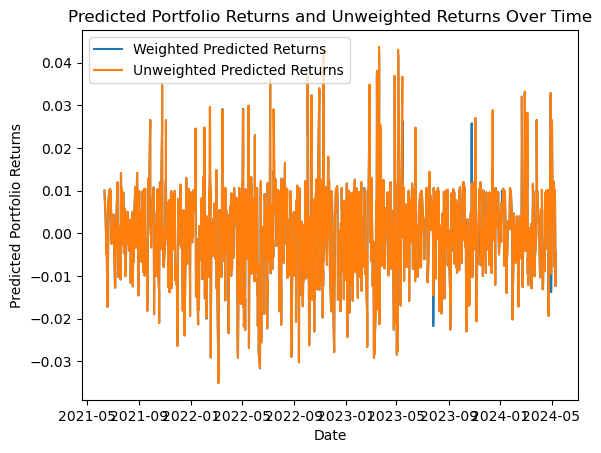

In [43]:
plt.plot(X_test.index, ensemble_predictions, label='Weighted Predicted Returns')
plt.plot(X_test_uw.index, ensemble_predictions_uw, label='Unweighted Predicted Returns')
# plt.plot(stock_returns.index, stock_returns['GOOGL'], label='Google Returns')
plt.xlabel('Date')
plt.ylabel('Predicted Portfolio Returns')
plt.title('Predicted Portfolio Returns and Unweighted Returns Over Time')
plt.legend()

plt.show()

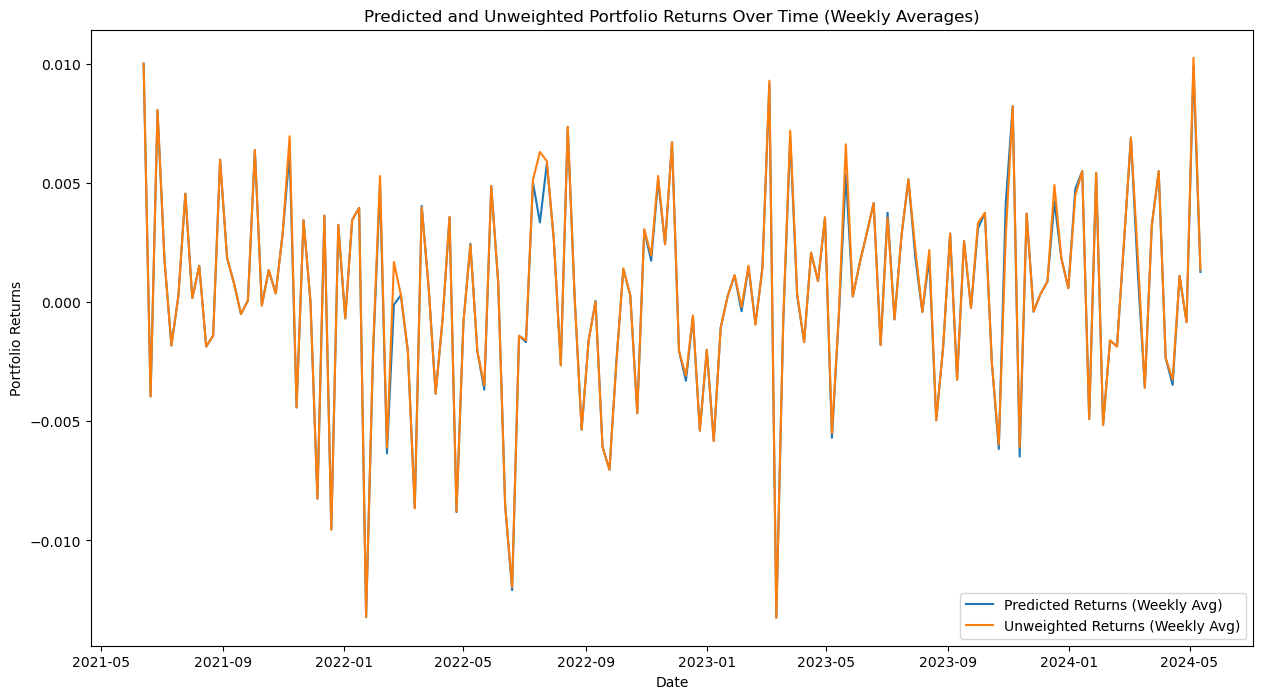

In [44]:
# Convert arrays to pandas Series (make sure `X_test.index` and `portfolio_df.index` are datetime indices)
predicted_returns_weighted = pd.Series(ensemble_predictions, index=X_test.index)
predicted_returns_unweighted = pd.Series(ensemble_predictions_uw, index=X_test_uw.index)

# Set the figure size
plt.figure(figsize=(15, 8))

# Resample the data to weekly averages
weekly_predicted_w = predicted_returns_weighted.resample('W').mean()
weekly_predicted_uw = predicted_returns_unweighted.resample('W').mean()

# Plot the resampled data
plt.plot(weekly_predicted_w.index, weekly_predicted_w, label='Predicted Returns (Weekly Avg)')
plt.plot(weekly_predicted_uw.index, weekly_predicted_uw, label='Unweighted Returns (Weekly Avg)')

# Labeling the axes and the plot
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Predicted and Unweighted Portfolio Returns Over Time (Weekly Averages)')
plt.legend()

# Show the plot
plt.show()

In [45]:
# Calculate the average predicted returns over the entire period
average_predicted_returns = weekly_predicted_w.std()

# Calculate the average unweighted returns over the entire period
average_unweighted_returns = weekly_predicted_uw.std()

print("Average Predicted Weighted Volatility over 3 years:", average_predicted_returns)
print("Average Predicted Unweighted Volatility over 3 years:", average_unweighted_returns)
print("Difference", average_unweighted_returns-average_predicted_returns)


Average Predicted Weighted Volatility over 3 years: 0.004356181625781063
Average Predicted Unweighted Volatility over 3 years: 0.004393903998661065
Difference 3.772237288000163e-05


## Calculating Real Unweighted Returns

In [46]:
# Calculating Portfolio return before Optimizing
# Assign equal weights to each stock
weights = [1/4] * 4  # Four stocks, equal weight

stock_returns = merged_df[['KRE', 'DIS', 'GOOGL', 'NG=F']].iloc[split_point:]
portfolio_returns = stock_returns.dot(weights)
portfolio_df = pd.DataFrame({'Portfolio Returns': portfolio_returns})

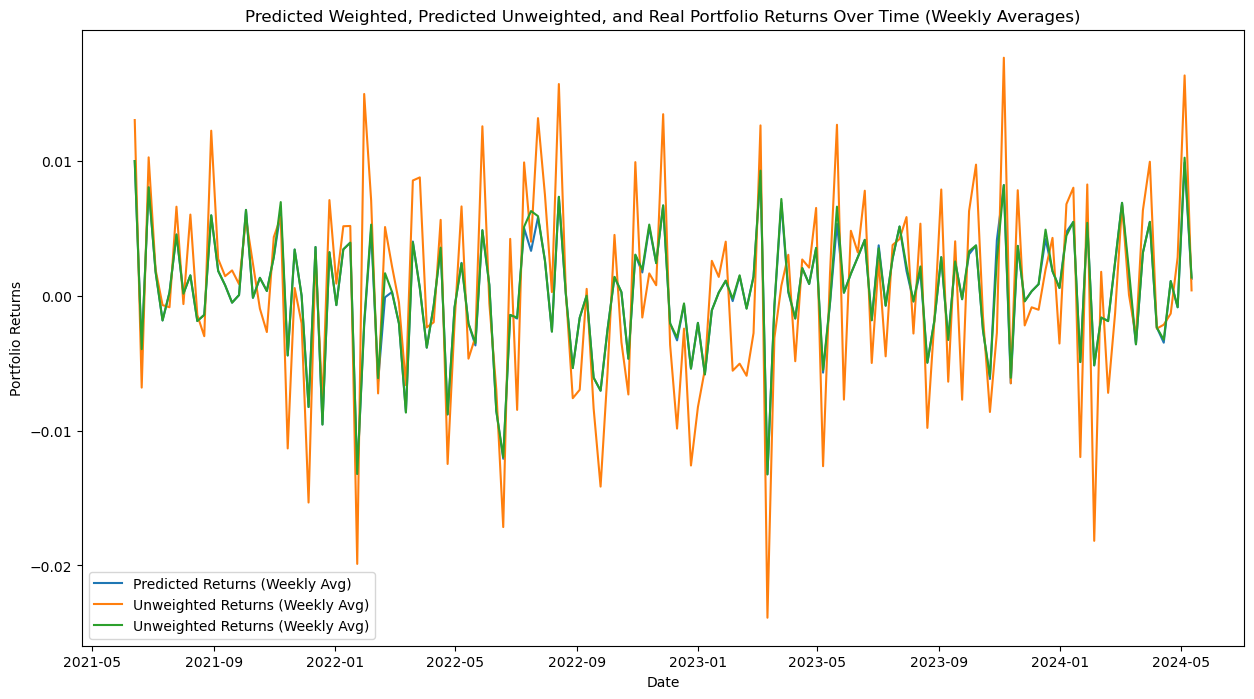

In [47]:
# Convert arrays to pandas Series (make sure `X_test.index` and `portfolio_df.index` are datetime indices)
predicted_returns_series = pd.Series(ensemble_predictions, index=X_test.index)
portfolio_returns_series = pd.Series(portfolio_df['Portfolio Returns'], index=portfolio_df.index)

# Set the figure size
plt.figure(figsize=(15, 8))

# Resample the data to weekly averages
weekly_predicted = predicted_returns_series.resample('W').mean()
weekly_unweighted = portfolio_returns_series.resample('W').mean()

# Plot the resampled data
plt.plot(weekly_predicted.index, weekly_predicted, label='Predicted Returns (Weekly Avg)')
plt.plot(weekly_unweighted.index, weekly_unweighted, label='Unweighted Returns (Weekly Avg)')
plt.plot(weekly_predicted_uw.index, weekly_predicted_uw, label='Unweighted Returns (Weekly Avg)')

# Labeling the axes and the plot
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Predicted Weighted, Predicted Unweighted, and Real Portfolio Returns Over Time (Weekly Averages)')
plt.legend()

# Show the plot
plt.show()

In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Defining features for both weighted and unweighted
X_weighted = merged_df[['KRE', 'DIS', 'GOOGL', 'NG=F', 'MA_10', 'STD_10', 'Previous_Returns', 'MA_10_close', 'MA_50_close']]
y_weighted = merged_df['Weighted_Returns']

X_unweighted = unweighted_merged_df[['KRE', 'DIS', 'GOOGL', 'NG=F', 'MA_10', 'STD_10', 'Previous_Returns', 'MA_10_close', 'MA_50_close']]
y_unweighted = unweighted_merged_df['Unweighted_Returns']

# Scale
scaler = StandardScaler()
X_weighted_scaled = scaler.fit_transform(X_weighted)
X_unweighted_scaled = scaler.transform(X_unweighted)  

# Using LSTM model, create sequences first from the feature sets above
def create_sequences(X, y, n_steps=10):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i-n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)
#it's just here to process the data in a way the LSTM model can process
n_steps = 10
X_weighted_seq, y_weighted_seq = create_sequences(X_weighted_scaled, y_weighted, n_steps)
X_unweighted_seq, y_unweighted_seq = create_sequences(X_unweighted_scaled, y_unweighted, n_steps)

# Define two LSTM models
def build_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Weighted Returns Model
model_weighted = build_model((n_steps, X_weighted_seq.shape[2]))
model_weighted.fit(X_weighted_seq, y_weighted_seq, epochs=10, validation_split=0.2)

# Unweighted Returns Model
model_unweighted = build_model((n_steps, X_unweighted_seq.shape[2]))
model_unweighted.fit(X_unweighted_seq, y_unweighted_seq, epochs=10, validation_split=0.2)

# seeing how it works
mse_weighted = model_weighted.evaluate(X_weighted_seq, y_weighted_seq)
mse_unweighted = model_unweighted.evaluate(X_unweighted_seq, y_unweighted_seq)

print(f'MSE for Weighted Returns Model: {mse_weighted:.4f}')
print(f'MSE for Unweighted Returns Model: {mse_unweighted:.4f}')


Epoch 1/10


c:\Users\sford\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0076 - val_loss: 7.2560e-04
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3878e-04 - val_loss: 6.0384e-04
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4768e-04 - val_loss: 3.7312e-04
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7250e-04 - val_loss: 2.9099e-04
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2942e-04 - val_loss: 2.8396e-04
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1581e-04 - val_loss: 2.9432e-04
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1290e-04 - val_loss: 1.9718e-04
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2684e-04 - val_loss: 2.0452e-04
Epoch 9/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4496e-05 - val_loss: 1.5539e-04
Epoch 10/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8969e-05 - val_loss: 1.4124e-04
Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0057 - val_l

306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


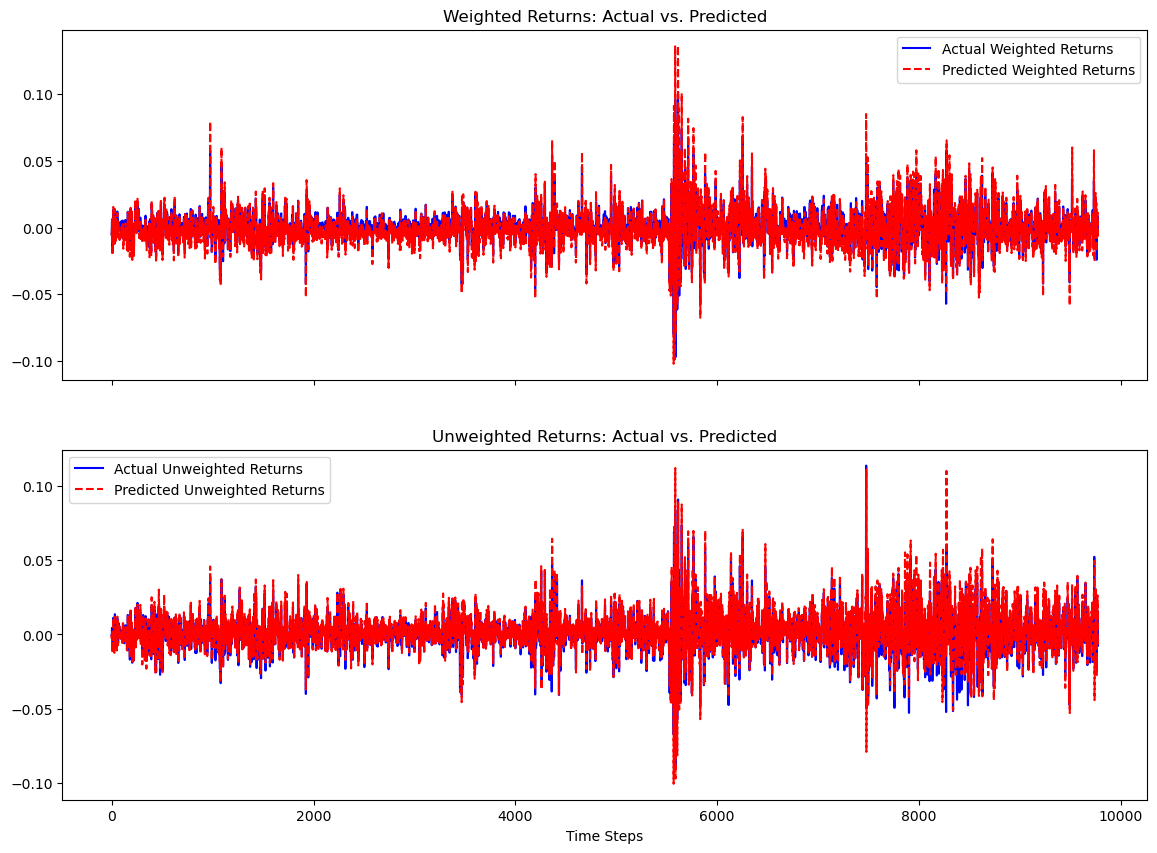

In [50]:
import matplotlib.pyplot as plt

# storing this stuff from above into a tidy dataframe type thing
predictions_weighted = model_weighted.predict(X_weighted_seq)
predictions_unweighted = model_unweighted.predict(X_unweighted_seq)

# the plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# weighted returns
axes[0].plot(y_weighted_seq, label='Actual Weighted Returns', color='blue')
axes[0].plot(predictions_weighted, label='Predicted Weighted Returns', color='red', linestyle='--')
axes[0].set_title('Weighted Returns: Actual vs. Predicted')
axes[0].legend()

# unweighted returns
axes[1].plot(y_unweighted_seq, label='Actual Unweighted Returns', color='blue')
axes[1].plot(predictions_unweighted, label='Predicted Unweighted Returns', color='red', linestyle='--')
axes[1].set_title('Unweighted Returns: Actual vs. Predicted')
axes[1].legend()

plt.xlabel('Time Steps')
plt.show()


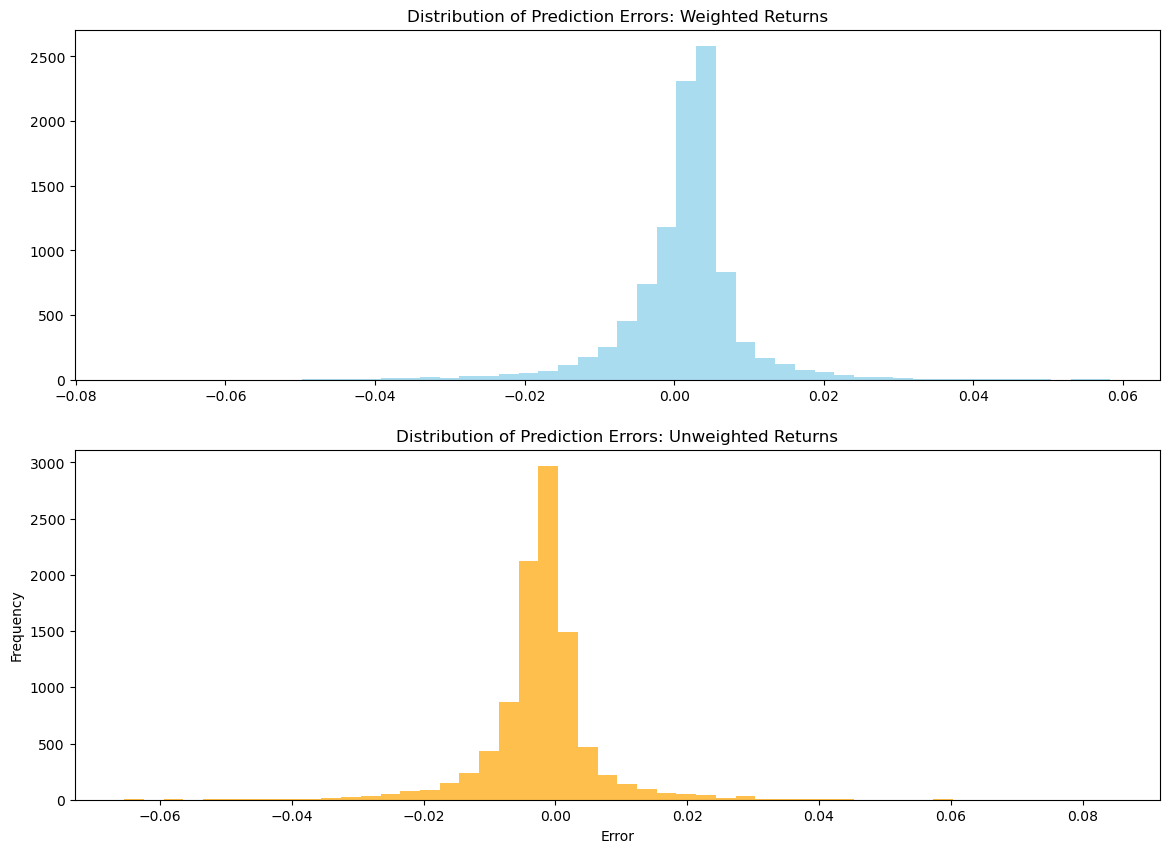

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# errors
errors_weighted = y_weighted_seq - predictions_weighted.flatten()
errors_unweighted = y_unweighted_seq - predictions_unweighted.flatten()

# plotting more errors
axes[0].hist(errors_weighted, bins=50, color='skyblue', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors: Weighted Returns')

# distribution
axes[1].hist(errors_unweighted, bins=50, color='orange', alpha=0.7)
axes[1].set_title('Distribution of Prediction Errors: Unweighted Returns')

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0078 - val_loss: 0.0011
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3579e-04 - val_loss: 4.5984e-04
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4230e-04 - val_loss: 4.2594e-04
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7846e-04 - val_loss: 3.5732e-04
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2227e-04 - val_loss: 2.5318e-04
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6643e-04 - val_loss: 2.7482e-04
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5481e-04 - val_loss: 2.2323e-04
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0875e-04 - val_loss: 2.1886e-04
Epoch 9/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2177e-04 - val_loss: 1.8577e-04
Epoch 10/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9871e-05 - val_loss: 2.8637e-04
Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0085 

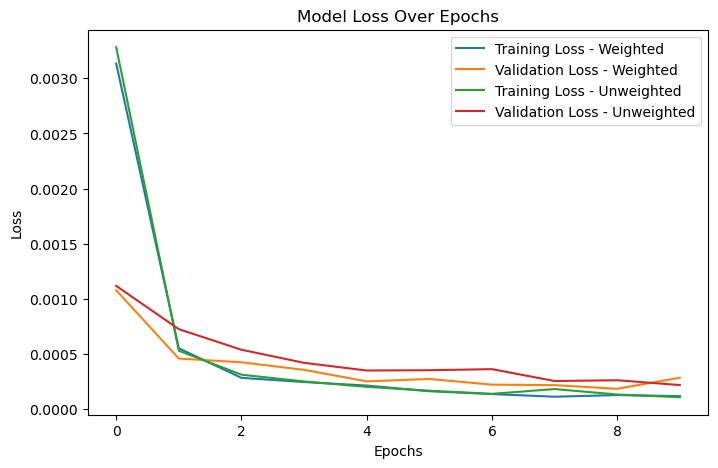

In [55]:
# The sequences help define the model so i could put it on a pretty graph, the shape (2) is standard because the data isn't that biased
model_weighted = build_model((n_steps, X_weighted_seq.shape[2]))
history_weighted = model_weighted.fit(X_weighted_seq, y_weighted_seq, epochs=10, validation_split=0.2)

# same for unweighted
model_unweighted = build_model((n_steps, X_unweighted_seq.shape[2]))
history_unweighted = model_unweighted.fit(X_unweighted_seq, y_unweighted_seq, epochs=10, validation_split=0.2)


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(history_weighted.history['loss'], label='Training Loss - Weighted')
ax.plot(history_weighted.history['val_loss'], label='Validation Loss - Weighted')
ax.plot(history_unweighted.history['loss'], label='Training Loss - Unweighted')
ax.plot(history_unweighted.history['val_loss'], label='Validation Loss - Unweighted')
ax.set_title('Model Loss Over Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()
